# CHECK THE RESULTS

### IMPORT NECESSARY MODULES

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp


from LOW_LEVEL_UTILITIES.utilities import show_batch, save_model, save_obj, load_model, load_obj, get_model_dictionary
from LOW_LEVEL_UTILITIES.utilities import dataset_in_memory, check_datasets
from simulation_dictionary import SimulationDictionary 
#from VAE.vae_model import VAE

import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceGraph_ELBO, TraceEnum_ELBO, JitTraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, Adamax, SGD

def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)

## Instantiate the Compositional_VAE

In [2]:
# %load VAE/vae_model.py
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from PIL import Image, ImageDraw
from LOW_LEVEL_UTILITIES.distributions import UniformWithTails, Indicator,IndicatorNew
import matplotlib.pyplot as plt
from VAE.vae_parts import Inference,Generator
import collections

class Compositional_VAE(torch.nn.Module):
    
    def __init__(self, params):
        super().__init__()
        
        # Instantiate the encoder and decoder
        self.inference = Inference(params)
        self.generator = Generator(params)
        
        #-------------------------#
        #------ Containers -------#
        #-------------------------#
        self.box_properties_tuple = collections.namedtuple('box_properties', 'bx_dimfull by_dimfull bw_dimfull bh_dimfull')
        self.z_mask_tuple         = collections.namedtuple('z_mask', 'r_coeff gamma0')
       
        #-------------------------#
        #--- Global Parameters ---#
        #-------------------------#
        self.Zwhat_dim      = params['ZWHAT.dim']
        self.size_raw_image =  params['IMG.size_raw_image'] 
        self.ch_raw_image   = len(params['IMG.ch_in_description']) 
        self.n_max_objects  = params['PRIOR.n_max_object'] 
        
        #---------------------------#
        #--- Pramatres Annealing ---#
        #---------------------------#
        self.ANN_protocol = params['ANNEALING.protocol'] 
        self.ANN_initial  = params['ANNEALING.prob_initial']
        self.ANN_final    = params['ANNEALING.prob_final']
        self.ANN_begin    = params['ANNEALING.begin']
        self.ANN_duration = params['ANNEALING.duration']
        
        #------------------------------------#
        #-- Parameters for the object size --#
        #------------------------------------#
        self.min_object_size = params['PRIOR.min_object_size'] 
        self.max_object_size = params['PRIOR.max_object_size'] 
        self.expected_object_size = params['PRIOR.expected_object_size'] 
        
        # Size of a object is uniform with tails between min_object_size and max_object_size  
        self.tails_object_size = 0.01*self.expected_object_size
        
        # Location of the BoundingBox centers is uniform in (-1,1) WITH exponential tails (decay on lenght scale 0.1)
        self.tails_bb_center = 0.01
        
        # Put everything on the cude if necessary
        self.use_cuda = params["use_cuda"]
        self.device = 'cuda' if self.use_cuda else 'cpu'
        if self.use_cuda:
            self.cuda()
            
    def annealing_prob_object(self,t):
        if(t is None):
            return 0.5
        if(self.ANN_protocol == "none"):
            return 0.5*np.ones_like(t)
        elif(self.ANN_protocol == "Linear"):
            x = (self.ANN_final - self.ANN_initial) * (t - self.ANN_begin) / self.ANN_duration + self.ANN_initial
            return np.maximum(np.minimum(x, self.ANN_initial), self.ANN_final)
        elif(self.ANN_protocol == "Exponential"):
            decay_rate = np.log(self.ANN_initial / self.ANN_final) / self.ANN_duration
            x = self.ANN_initial * np.exp(-decay_rate * (t - self.ANN_begin))
            return np.maximum(np.minimum(x, self.ANN_initial), self.ANN_final)
            

    def show_priors(self):
        one  = torch.tensor([1.0])
        if(self.use_cuda):
            # put these two TENSORS on the GPU
            # Note that scalar times tensor is a tensor with the sdame device
            one=one.cuda()
            
        zero = 0.0 * one
        z_prior           = dist.Normal(zero,one)
        size_object_prior = UniformWithTails(self.min_object_size*one,self.max_object_size*one,self.tails_object_size*one)
        bb_center_prior   = UniformWithTails(zero,one*self.size_raw_image,self.tails_bb_center*self.size_raw_image)
        
        cdf = torch.arange(start=0.0, end=1.0, step=0.001, dtype=torch.float, device=one.device)
        
        z_x = z_prior.icdf(cdf)
        z_y = torch.exp(z_prior.log_prob(z_x))
        
        size_object_x = size_object_prior.icdf(cdf)
        size_object_y = torch.exp(size_object_prior.log_prob(size_object_x))
        
        bb_center_x = bb_center_prior.icdf(cdf)
        bb_center_y = torch.exp(bb_center_prior.log_prob(bb_center_x)) 

        epoch_max = 1.2*( self.ANN_duration + self.ANN_begin)
        annealing_x_np = np.arange(start=0, stop=epoch_max, step=1)
        annealing_y_np = self.annealing_prob_object(annealing_x_np)
        annealing_x=torch.from_numpy(annealing_x_np).to(one.device)
        annealing_y=torch.from_numpy(annealing_y_np).to(one.device)
        
        # Create a plot with the priors
        fontsize=20
        labelsize=20
        fig, axs = plt.subplots(2, 2, figsize=(15,15))
        
        axs[0,0].set_xlabel('z_what [dimless]',fontsize=fontsize)
        axs[0,0].set_title('N(0,1)',fontsize=fontsize)
        axs[0,0].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[0,0].plot(z_x.cpu().numpy(),z_y.cpu().numpy())
        
        axs[0,1].set_xlabel('size bounding box [pixels]',fontsize=fontsize)
        axs[0,1].set_title('UniformWithTails',fontsize=fontsize)
        axs[0,1].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[0,1].plot(size_object_x.cpu().numpy(),size_object_y.cpu().numpy())
        
        axs[1,0].set_xlabel('location bounding_box [dimfull]',fontsize=fontsize)
        axs[1,0].set_title('UniformWithTails',fontsize=fontsize)
        axs[1,0].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[1,0].plot(bb_center_x.cpu().numpy(),bb_center_y.cpu().numpy())
        
        axs[1,1].set_xlabel('epoch',fontsize=fontsize)
        axs[1,1].set_title('Annealing Protocoll',fontsize=fontsize)
        axs[1,1].tick_params(axis='both', which='major', labelsize=labelsize)
        axs[1,1].plot(annealing_x_np,annealing_y_np)
        
        plt.subplots_adjust(wspace=0.4, hspace=0.3)

        return z_x,z_y,size_object_x,size_object_y,bb_center_x,bb_center_y,annealing_x,annealing_y     


    def model(self, imgs=None, epoch=None, generate_data=False):
        """ The MODEL takes a mini-batch of images and:
            1.  sample the latent from the prior:
                - z ~ N(0,1)
                - presence of a cell ~ Bernulli(p)
                - cxcy ~ uniform (-1,+1)
                - dxdy ~ gamma(alpha,beta) 
            2.  runs the generative model
            3A. If imgs = None then
                score the generative model against actual data 
                (it requires a noise model and fix the reconstruction loss)
            3B. Else
                return the generated image
                
            This is a trick so that by passing imgs=None I can:
            1. effectively test the priors
            2. debug shapes by using poutine.trace
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch_raw_image,self.size_raw_image,self.size_raw_image)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
               
        # Extract the info about image shape and prepare 0 and 1 on the same device as the image
        assert(len(imgs.shape)==4)
        batch_size,ch,width,height = imgs.shape
        zero = imgs.new_zeros(1)
        one = imgs.new_ones(1)
        
        # register all the parameters
        pyro.module("generator", self.generator)
        sigma = pyro.param("sigma", 0.1*one)
        loc   = pyro.param("loc", 0.2*one)
        scale = pyro.param("scale", 0.1*one)
        
        with pyro.plate("batch", batch_size, dim=-2):
            
            with pyro.plate("n_objects", self.n_max_objects, dim =-1):
            
                #------------------------#
                # 1. Sample from priors -#
                #------------------------#
                z_what = pyro.sample("latent_z",
                        dist.Normal(zero,one).expand([self.Zwhat_dim]).to_event(1))
            
                # Location of bounding box
                bx_dimfull = pyro.sample("bx_dimfull",
                        UniformWithTails(zero,one*width,self.tails_bb_center*width).expand([1]).to_event(1))
                by_dimfull = pyro.sample("by_dimfull",
                        UniformWithTails(zero,one*height,self.tails_bb_center*height).expand([1]).to_event(1))
            
                # Size of bounding box
                bw_dimfull = pyro.sample("bw_dimfull", UniformWithTails(self.min_object_size*one,self.max_object_size*one,
                                                                        self.tails_object_size*one).expand([1]).to_event(1))
                bh_dimfull = pyro.sample("bh_dimfull", UniformWithTails(self.min_object_size*one,self.max_object_size*one,
                                         self.tails_object_size*one).expand([1]).to_event(1))
            
                #------------------------------#
                # 2. Run the generative model -#
                #------------------------------#
                box_properties = self.box_properties_tuple(bx_dimfull=bx_dimfull,
                                                      by_dimfull=by_dimfull,
                                                      bw_dimfull=bw_dimfull,
                                                      bh_dimfull=bh_dimfull)
                z_mask = self.z_mask_tuple(r_coeff=torch.zeros(5), gamma0=torch.zeros(5)) # this is fake for now
                putative_imgs,putative_masks = self.generator.forward(box_properties,z_what,z_mask,width,height)  

                if(observed):
                    
                    # Compute the background loss
                    obs_imgs = imgs.unsqueeze(1) #add a singleton for the n_object dimension
                    definitely_bg_mask = 1 - torch.clamp(torch.sum(putative_masks,dim=-4,keepdim=True),max=1)
                    d_bg = dist.Cauchy(loc,scale).expand(obs_imgs.shape).mask(definitely_bg_mask).to_event(3)
                    loss_bg = d_bg.log_prob(obs_imgs)
                    assert loss_bg.shape  == (batch_size,1)

                    # Compute the loss when the object are BACKGROUND
                    obs_imgs = obs_imgs.expand(-1,self.n_max_objects,-1,-1,-1)
                    d_off = dist.Cauchy(loc,scale).expand(obs_imgs.shape).mask(putative_masks).to_event(3)
                    loss_off = d_off.log_prob(obs_imgs)
                    assert loss_off.shape == (batch_size,self.n_max_objects)
                
                    # Compute the loss when the object are FOREGOUND
                    d_on = dist.Normal(putative_imgs,sigma).mask(putative_masks).to_event(3)
                    loss_on = d_on.log_prob(obs_imgs)
                    assert loss_on.shape == (batch_size,self.n_max_objects)
                
                    # This is the effective loss to attribute to each ACTIVE box variable
                    # Note that I am dividing the background loss by the number of ACTIVE objects 
                    # so that, after enumeration over all ACTIVE boxes, the entire background is counted once.
                    #loss_0 = loss_off + loss_bg/self.n_max_objects
                    #loss_1 = loss_on  + loss_bg/self.n_max_objects
                
                    loss_0 = (loss_off + loss_bg/self.n_max_objects).unsqueeze(-1)
                    loss_1 = (loss_on  + loss_bg/self.n_max_objects).unsqueeze(-1)
                    loss_2 = torch.zeros_like(loss_0)
                    logits = torch.cat((loss_0,loss_1,loss_2),dim=-1)
                    assert loss_0.shape == (batch_size,self.n_max_objects,1)
                    assert loss_1.shape == (batch_size,self.n_max_objects,1)
                    assert loss_2.shape == (batch_size,self.n_max_objects,1)
                
                #---- THIS IS OUTSIDE THE if(observed) BLOCK
                # Note that here:
                # c=0 means that the box is a background
                # c=1 means that the box is foreground, i.e. it contains an object
                # c=2 means that the box is inactive (because double counting)
                p_prior = self.annealing_prob_object(epoch)
                p_cat = torch.tensor([1-p_prior,p_prior,0.001]).to(one.device)
                c = pyro.sample("prob_object",dist.Categorical(probs = p_cat))
                #---- THIS IS OUTSIDE THE if(observed) BLOCK
                
                
                if(observed):
                    pyro.sample("object_loss", IndicatorNew(logits=logits), obs = c)
                    
                if(generate_data):
                    background = dist.Cauchy(loc,scale).expand(imgs.shape).sample()
                else:
                    background = torch.zeros_like(imgs)
                
                return putative_imgs,putative_masks,background,c
        
    def guide(self, imgs=None, epoch=None, generate_data=False):
        
        """ The GUIDE takes a mini-batch of images and: 
            1. run the inference to get: zwhere,zwhat
            2. sample:
                - z ~ N(z_mu, z_std) where each component of z is drawn independently
                - c ~ Bernulli(p)
                - cxcy ~ N(cxcy_mu,0.1) 
                - dxdy ~ gamma(dxdy_mu,0.1) 
        """
        
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            imgs = torch.zeros(8,self.ch_raw_image,self.size_raw_image,self.size_raw_image)
            if(self.use_cuda):
                imgs=imgs.cuda()
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        #print("GUIDE")
        pyro.module("inference",self.inference)
        batch_size,ch,width,height = imgs.shape    
        one = imgs.new_ones(1)
        assert(width == height) 
        
        std_bx_dimfull = pyro.param("std_bx_dimfull", one)
        std_by_dimfull = pyro.param("std_by_dimfull", one)
        std_bw_dimfull = pyro.param("std_bw_dimfull", one)
        std_bh_dimfull = pyro.param("std_bh_dimfull", one)

        with pyro.plate("batch", batch_size, dim =-2 ):
            
            #--------------------------#
            #-- 1. run the inference --#
            #--------------------------#          
            z_nms = self.inference.forward(imgs)
            
            # Unpack the variables
            p          = z_nms.z_where.prob
            bx_dimfull = z_nms.z_where.bx_dimfull
            by_dimfull = z_nms.z_where.by_dimfull
            bw_dimfull = z_nms.z_where.bw_dimfull
            bh_dimfull = z_nms.z_where.bh_dimfull
            z_mu       = z_nms.z_what.z_mu 
            z_std      = z_nms.z_what.z_std 
            r_coeff_mu = z_nms.z_mask.r_coeff_mu
            r_coeff_std= z_nms.z_mask.r_coeff_mu
            gamma0_mu  = z_nms.z_mask.gamma0_mu
            gamma0_std = z_nms.z_mask.gamma0_std

            with pyro.plate("n_objects", self.n_max_objects, dim =-1 ):
                     
                #---------------#    
                #-- 2. Sample --#
                #---------------#
                   
                # Latent z
                pyro.sample("latent_z",dist.Normal(z_mu, z_std).to_event(1))
            
                # Centers
                # Location of bounding box
                pyro.sample("bx_dimfull",dist.Normal(bx_dimfull, std_bx_dimfull).to_event(1))
                pyro.sample("by_dimfull",dist.Normal(by_dimfull, std_by_dimfull).to_event(1))
                
                # Size of Bounding Box 
                pyro.sample("bw_dimfull",dist.Normal(bw_dimfull, std_bw_dimfull).to_event(1)) 
                pyro.sample("bh_dimfull",dist.Normal(bh_dimfull, std_bh_dimfull).to_event(1))
                
                # Coefficient for mask
                #pyro.sample("r_coeff",dist.Normal(r_coeff_mu, r_coeff_std).to_event(1))
                #pyro.sample("gamma0",dist.LogNormal(gamma0_mu, gamma0_std).to_event(1))
                
                # Prob of an object 
                # c=0 means that the box is a background. (probability 1-p)
                # c=1 means that the box is foreground, i.e. it contains an object, (probability p)
                # c=2 means that the box is inactive (because double counting)
                mask_p_gt_0 = (p>0.0).float()
                one_minus_p = (1.0-p)
                p_cat = torch.cat((one_minus_p*mask_p_gt_0,p*mask_p_gt_0,1-mask_p_gt_0),dim=-1)
                c = pyro.sample("prob_object",dist.Categorical(probs = p_cat))
                

    def reconstruct_img(self,original_image,bounding_box=False):
        if(self.use_cuda):
            original_image=original_image.cuda()
        
        batch_size,ch,width,height = original_image.shape
        assert(width==height)
        self.eval() # set the model into evaluation mode
        with torch.no_grad(): # do not keep track of the gradients
            
            #--------------------------#
            #-- 1. run the inference --#
            #--------------------------#          
            z_nms = self.inference.forward(original_image)
            
            # Unpack the variables
            p          = z_nms.z_where.prob
            bx_dimfull = z_nms.z_where.bx_dimfull
            by_dimfull = z_nms.z_where.by_dimfull
            bw_dimfull = z_nms.z_where.bw_dimfull
            bh_dimfull = z_nms.z_where.bh_dimfull
            z_mu       = z_nms.z_what.z_mu 
            z_std      = z_nms.z_what.z_std 
            r_coeff_mu = z_nms.z_mask.r_coeff_mu
            r_coeff_std= z_nms.z_mask.r_coeff_mu
            gamma0_mu  = z_nms.z_mask.gamma0_mu
            gamma0_std = z_nms.z_mask.gamma0_std
            
            #--------------------------------#
            #--- 2. Run the model forward ---#
            #--------------------------------#
            box_properties = self.box_properties_tuple(bx_dimfull=bx_dimfull,
                                                       by_dimfull=by_dimfull,
                                                       bw_dimfull=bw_dimfull,
                                                       bh_dimfull=bh_dimfull)
            z_mask = self.z_mask_tuple(r_coeff=torch.zeros(5), gamma0=torch.zeros(5)) # this is fake for now
            putative_imgs,putative_masks = self.generator.forward(box_properties,z_mu,z_mask,width,height)     
            
            #---------------------------------#
            #----- 3. Reconstruct images -----#
            #---------------------------------#
            object_is_on = (p>0.5)[...,None,None].float()
            reconstructed_image = torch.sum(object_is_on*putative_imgs*putative_masks,dim=-4,keepdim=False)
            
            # 3. If bounding_box == True compute the bounding box
            if(bounding_box == False):
                return reconstructed_image,p,box_properties
            elif(bounding_box == True):
                bounding_boxes = self.draw_batch_of_images_with_bb_only(width,height,p,box_properties)
                reconstructed_image_with_bb = bounding_boxes + reconstructed_image.expand(-1,3,-1,-1)
                return reconstructed_image_with_bb,p,box_properties
    
    def draw_batch_of_images_with_bb_only(self,width,height,p,box_properties):
       
        batch_size,n_boxes = p.shape[:2]
        batch_bb_np    = np.zeros((batch_size,width,height,3)) # numpy storage for bounding box images
        
        # compute the coordinates of the bounding boxes
        x1 = box_properties.bx_dimfull-0.5*box_properties.bw_dimfull
        x3 = box_properties.bx_dimfull+0.5*box_properties.bw_dimfull
        y1 = box_properties.by_dimfull-0.5*box_properties.bh_dimfull
        y3 = box_properties.by_dimfull+0.5*box_properties.bh_dimfull
        assert( len(x1.shape) == 3) 
        x1y1x3y3 = torch.cat((x1,y1,x3,y3),dim=2)
                
        # draw the bounding boxes
        for b in range(batch_size):
        
            # Draw on PIL
            img = Image.new('RGB', (width,height), color=0)
            draw = ImageDraw.Draw(img)
            for i in range(n_boxes):
                if(p[b,i,0]>0.0):
                    #draw.polygon(x1y1x2y2x3y3x4y4[b,i,:].cpu().numpy(), outline='red', fill=None)
                    draw.rectangle(x1y1x3y3[b,i,:].cpu().numpy(), outline='red', fill=None)
            batch_bb_np[b,...] = np.array(img.getdata(),np.uint8).reshape(width,height,3)

        # Transform np to torch, rescale from [0,255] to (0,1) 
        batch_bb_torch = torch.from_numpy(batch_bb_np).permute(0,3,1,2).float()/255
        return batch_bb_torch.to(p.device)   
           
    def generate_synthetic_data(self, N=100):
        
        # preparation
        putative_imgs,putative_masks,background,c = self.model(generate_data=True)
        mask_boxes_are_on = (c[...,None,None,None]==1).float()
        imgs_prior = torch.sum((putative_imgs*putative_masks*mask_boxes_are_on),dim=-4) + background
        batch,ch,width,height = imgs_prior.shape 
        synthetic_data = torch.zeros((N, ch, width, height), dtype=torch.float32, device='cpu', requires_grad=False) 
        
        l = 0 
        while (l<N):         
            # Compute left and right indeces
            r = min(l+batch,N)
            d = r-l
            synthetic_data[l:r,:,:,:]=imgs_prior[0:d,:,:,:].detach().cpu()
            l = r
            putative_imgs,putative_masks,background,c = self.model(generate_data=True)
            mask_boxes_are_on = (c[...,None,None,None]==1).float()
            imgs_prior = torch.sum((putative_imgs*putative_masks*mask_boxes_are_on),dim=-4) + background

        return torch.clamp(synthetic_data,min=0.0, max=1.0)

In [2]:
write_dir = '/home/ldalessi/spacetx-research/non_overlapping_masks/ARCHIVE/'
params = load_obj(write_dir,"params_disk_mask_v10")
print(params)

{'ZWHAT.dim': 50, 'ZMASK.dim': 8, 'ANNEALING.protocol': 'Linear', 'ANNEALING.prob_initial': 0.99999, 'ANNEALING.prob_final': 1e-06, 'ANNEALING.begin': 100, 'ANNEALING.duration': 200, 'PRIOR.n_max_objects': 6, 'PRIOR.min_object_size': 10, 'PRIOR.max_object_size': 35, 'PRIOR.expected_object_size': 30, 'IMG.size_raw_image': 80, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'SD.width': 32, 'SD.dim_h1': 400, 'SD.dim_h2': -1, 'YOLO.p_threshold': 0.0, 'YOLO.IoU_threshold': 0.2, 'use_cuda': True}


# Load from file

In [22]:
write_dir = '/home/ldalessi/spacetx-research/parallel_enum_annealing_v2/ARCHIVE/'
TEST_FREQUENCY = 5
name_vae        = "vae_disk_v4_"
name_train_loss = "train_loss_disk_v4_"
name_test_loss  = "test_loss_disk_v4_"
name_params     = "params_disk_v4"

epoch = 540

reference_imgs = load_obj(write_dir,"reference_imgs")
params = load_obj(write_dir,name_params)
vae = Compositional_VAE(params)
load_model(vae,write_dir,name_vae+str(epoch))
test_loss = load_obj(write_dir,name_test_loss+str(epoch))
train_loss = load_obj(write_dir,name_train_loss+str(epoch))
print(params)

{'ZWHAT.dim': 50, 'ZMASK.dim': 5, 'ANNEALING.protocol': 'Exponential', 'ANNEALING.prob_initial': 0.5, 'ANNEALING.prob_final': 1e-06, 'ANNEALING.begin': 10, 'ANNEALING.duration': 200, 'PRIOR.n_max_object': 6, 'PRIOR.min_object_size': 10, 'PRIOR.max_object_size': 35, 'PRIOR.expected_object_size': 30, 'IMG.size_raw_image': 80, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'SD.width': 32, 'SD.dim_h1': 400, 'SD.dim_h2': -1, 'YOLO.p_threshold': 0.0, 'YOLO.IoU_threshold': 1e-05, 'use_cuda': True}


# Check the results

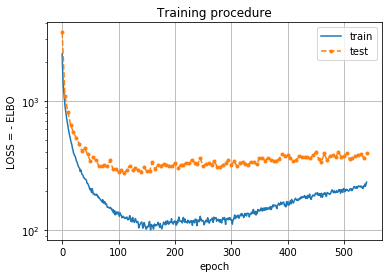

In [23]:
plt.yscale('log')
y_shift=500
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(train_loss)), np.array(train_loss)+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(train_loss), TEST_FREQUENCY), np.array(test_loss)+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax = 2000, ymin = 100)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'train.png')

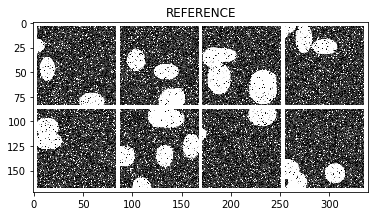

In [24]:
#show_batch(reference_imgs[:8],nrow=4,npadding=4)

from matplotlib import pyplot as mp
a = show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+'reference.png')


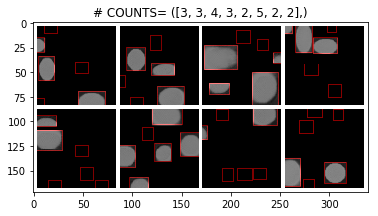

In [25]:
rec_img,p,box_properties = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(p>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'rec.png')


# MAKE MOVIE

In [ ]:
from matplotlib import pyplot as mp

l=0
for epoch in range(0,700,20):
    if(epoch<10):
        label ="00"+str(epoch)
    elif(epoch<100):
        label = "0"+str(epoch)
    else:
        label = str(epoch)
    print(label)
    load_model(vae,write_dir,"vae_disk_v2_"+str(epoch))
    rec_img,p,bx,by,bw,bh = vae.reconstruct_img(imgs_in,True)
    a = show_batch(rec_img[:4],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
    mp.savefig(write_dir+'img_rec_v2_'+label+'.png')
    l += 1    